# Counting DL and DLT histories
### Cedric Chauve, 07/03/2019

### Abstract.
This notebook contains the code used to analyse our experimental results and generate figures that are presented in the paper. 

In [1]:
# Hiding te code from the notebook

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import io
import math

## Introduction

In this notebook, we consider 4 *models*: unranked DL (*UDL*), ranked Dl (*RDL*), unranked DLT (*UDLT*) and ranked DLT (*RDLT*). For each model, we generated $100$ species tree of size $k$ as follows: the caterpillar, if $k$ is a power of $2$, the compkete binary tree, and the remaining species trees are generated at rendom under the uniform distribution. Note that in this setting, for small values of $k$, some species trees are generated several times. Moreover, in the two ranked model, for each species tree, we generated $10$ random rankings, again chosen under the uniform distribution. Finally for each input (to be understood as a species tree $S$ of size $k$, together with a ranking if we are in a ranked model), we counted the number of histories (in the chosen model) of size $n$. Our range parameter is $k \in [3,25]$ and $n\in [1,50]$.

In [3]:
# Parameters

# Number of species trees per size
NB_S_TREES    = 100
S_TREES_INDEX = [i for i in range(0,NB_S_TREES)]
# Evolutionary models
EVOL_MODELS = [('U','DL'),('U','DLT'),('R','DL'),('R','DLT')]
MODEL2LEGEND = {'U_DL': 'UDL model',
                'U_DLT': 'UDLT model',
                'R_DL': 'RDL model',
                'R_DLT': 'RDLT model'}
# Species tree sizes
K_MIN = 3
K_MAX = 25 #target: 32 but computations did not finish past k=26
K_LIST = [k for k in range(K_MIN,K_MAX+1)]
# Histories sizes
N_MIN = 1
N_MAX = 50
N_LIST = [n for n in range(N_MIN,N_MAX+1)]
# Paths to results
PREFIX_UNRANKED    = '../../exp/09-01-2019-exp1-redone/results/exp1a'
PREFIX_RANKED      = '../../exp/01-02-2019-exp1-ranking/results/exp1'
PREFIX_ASYMPTOTICS = '../../exp/29-01-2019-exp1-redone-2/systems/exp1a'
PREFIX_SCORES      = '../../exp/06-02-2019-score-distribution/results/samples_'
# Rankings
R_MAX  = 10
R_LIST = [r for r in range(1,R_MAX+1)]

In [4]:
# Subset of the parameter space for more readable figures
K_LIST_REDUCED = [10,15,20,25]
K_LIST_POW2    = [4,8,16]
N_LIST_REDUCED = [10,20,30,40,50]

In [7]:
# Reading the exact counting results
# Format: RESULTS_ALL[evol_model][s][n][tree_index] is 
# the list of the number of histories of size n for tree tree_index of size s in model evol_model 
# the list is of size 1 if the tree is unranked

RESULTS_aux = {m:{k:{n:{t:[] for t in S_TREES_INDEX} for n in N_LIST}  for k in K_LIST} for m in EVOL_MODELS}
    
def read_counting_file(fileName,k):
    with gzip.open(fileName, 'r') as f:
        reader = csv.reader(io.TextIOWrapper(f, newline=""),delimiter='\t')        
        for row in reader:
            if row[0][0]!='#':
                model     = (row[2],row[3])
                treeIndex = int(row[1])
                row5      = row[5].split()
                for n in N_LIST:
                    RESULTS_aux[model][k][n][treeIndex].append(int(row5[n-1]))
    
for k in K_LIST:
    read_counting_file(PREFIX_UNRANKED+'_'+str(k)+'.gz',k)
    read_counting_file(PREFIX_RANKED+'_'+str(k)+'.gz',k)
                            
RESULTS_COUNTING = pd.DataFrame.from_dict({(m,k,n): RESULTS_aux[m][k][n]
                                            for m in RESULTS_aux.keys() 
                                            for k in RESULTS_aux[m].keys()
                                            for n in RESULTS_aux[m][k].keys()},
                                            orient='index')

In [8]:
# Reading the exact asymptotics (growth factor) results for the model UDL

RESULTS_aux = {k:{t:0 for t in S_TREES_INDEX}  for k in K_LIST}
for k in K_LIST:
    dataAsympt = open(PREFIX_ASYMPTOTICS+'_'+str(k)+'_asy').readlines()
    for row in dataAsympt:
        if row[0] != '#':
            row1        = row.rstrip().split('\t')
            treeIndex   = int(row1[1])
            asymptotics =  float(row1[2])
            RESULTS_aux[k][treeIndex] = asymptotics
RESULTS_ASYMPTOTICS_U_DL = pd.DataFrame.from_dict({(k): RESULTS_aux[k]
                                                for k in RESULTS_aux.keys()},
                                                orient='index')

In [9]:
# Reading the number of subtrees and the height per species tree

RESULTS_aux = {k:{t:0 for t in S_TREES_INDEX}  for k in K_LIST}
for k in K_LIST:
    subtrees = open(PREFIX_UNRANKED+'_'+str(k)+'_add1').readlines()
    for row in subtrees:
        if row[0] != '#':
            row1        = row.rstrip().split('\t')
            treeIndex   = int(row1[1])
            nbSubtrees    = row1[3].count('(')
            RESULTS_aux[k][treeIndex] = nbSubtrees
RESULTS_SUBTREES = pd.DataFrame.from_dict({(k): RESULTS_aux[k]
                                                for k in RESULTS_aux.keys()},
                                                orient='index')

RESULTS_aux = {k:{t:0 for t in S_TREES_INDEX}  for k in K_LIST}
for k in K_LIST:
    subtrees = open(PREFIX_UNRANKED+'_'+str(k)+'_add2').readlines()
    for row in subtrees:
        if row[0] != '#':
            row1        = row.rstrip().split('\t')
            treeIndex   = int(row1[1])
            height      = int(row1[3])
            RESULTS_aux[k][treeIndex] = height
RESULTS_HEIGHT = pd.DataFrame.from_dict({(k): RESULTS_aux[k]
                                                for k in RESULTS_aux.keys()},
                                                orient='index')

## Asymptotics in the unranked DL model

We first look at the simplest model, the U-DL model, where we can obtain theortical asymptotics estimates. Here we assume that for a given species tree $S$ and a given history size $n$, we have
$$h_S(n) \simeq \gamma_S \frac{\alpha_S^n}{n^{3/2}}\left(1+O\left(\frac{1}{n}\right)\right).$$
We call $\alpha_S$ the *growth factor* and $\gamma_S$ the *constant*.

**Method.** Currently, Michael generates, from the input tree, the set of equations whose solution gives the growth factor. This set of equations is then solved using *SciPy* to obtain $\alpha_S$. To approximate $\alpha_S$, we take the exact counting term at $h_S({50})$ and divides it by $n^{3/2}/\gamma_S$.

<Figure size 432x288 with 0 Axes>

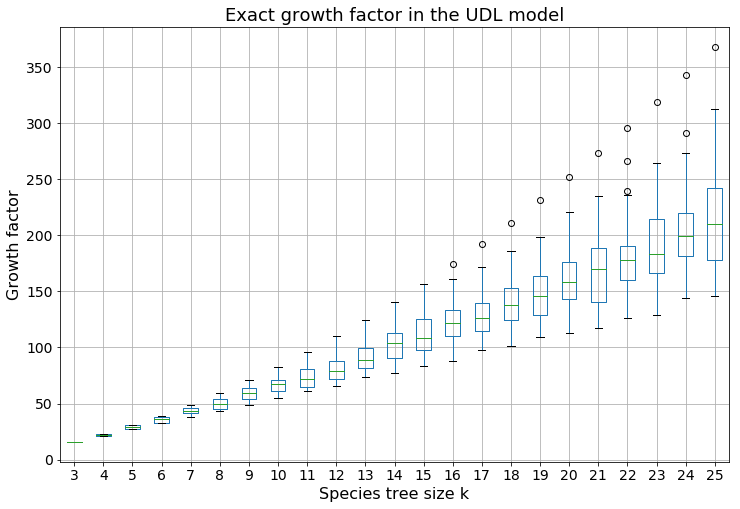

In [10]:
plt.figure()
ax_asympt1 = RESULTS_ASYMPTOTICS_U_DL.transpose().plot(kind='box', grid=True, return_type='axes', figsize=(12,8), title='Exact growth factor in the UDL model', fontsize=14)
ax_asympt1.title.set_size(18)
ax_asympt1.set_ylabel('Growth factor', fontsize=16)
ax_asympt1.set_xlabel('Species tree size k', fontsize=16)
plt.savefig('paper/computed_growth_factor_U_DL.png')
plt.show()

We can observe that the minimum and median value seem to grow linearly, while the max value seems to grow non-linearly. Note however that this is over a sample of species tree so the results might not be extremely robust for larger values of $k$. 

We now look at the constants $\gamma_S$.

In [11]:
# Computing the constants
CONSTANTS_U_DL_aux = {k:{t:0 for t in S_TREES_INDEX}  for k in K_LIST}
for k in K_LIST:
    for t in S_TREES_INDEX:
        n = N_MAX
        exact    = RESULTS_COUNTING.at[(('U','DL'),k,n),t][0]
        growth   = RESULTS_ASYMPTOTICS_U_DL.at[k,t]
        asympt   = math.pow(growth,n) / math.pow(n,1.5)
        constant = exact / asympt
        CONSTANTS_U_DL_aux[k][t] = constant
CONSTANTS_U_DL = pd.DataFrame.from_dict({k: CONSTANTS_U_DL_aux[k]
                                        for k in CONSTANTS_U_DL_aux.keys()},
                                        orient='index')

<Figure size 432x288 with 0 Axes>

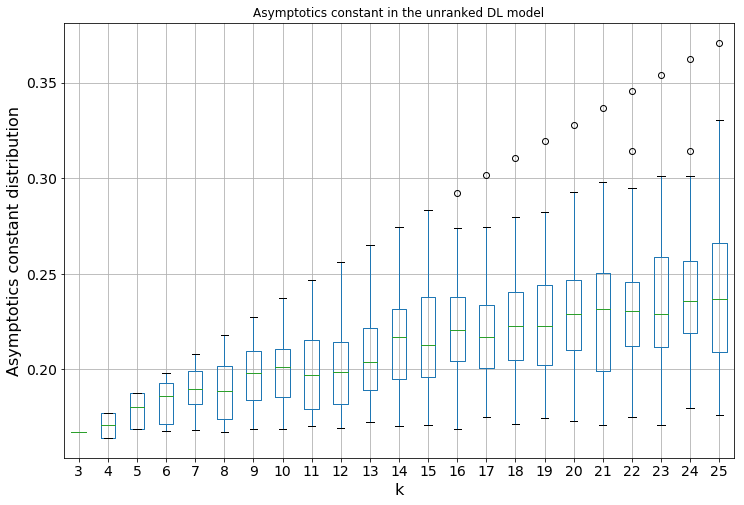

In [12]:
plt.figure()
ax_asympt2 = CONSTANTS_U_DL.transpose().plot(kind='box', grid=True, return_type='axes', figsize=(12,8), title='Asymptotics constant in the unranked DL model', fontsize=14)
ax_asympt2.set_ylabel('Asymptotics constant distribution', fontsize=16)
ax_asympt2.set_xlabel('k', fontsize=16)
plt.savefig('paper/constants_U_DL.png')
plt.show()

We can observe that the max constant grows linearly, but otherwise we have a much less nice growng pattern than for the growth factor.

We are now looking at the species tree that leads to extreme growth factor.

In [13]:
def check_min_max_growth_factor(df):
    df_min = df.idxmin(axis=1)
    df_max = df.idxmax(axis=1)
    for k in K_LIST:
        if df_max[k] == 0:
            print('k = '+str(k)+': species tree with max. growth constant is the caterpillar')
        if k in K_LIST_POW2 and df_min[k] == 1:
            print('k = '+str(k)+': species tree with min. growth constant is the complete binary tree')
check_min_max_growth_factor(RESULTS_ASYMPTOTICS_U_DL)

k = 3: species tree with max. growth constant is the caterpillar
k = 4: species tree with max. growth constant is the caterpillar
k = 4: species tree with min. growth constant is the complete binary tree
k = 5: species tree with max. growth constant is the caterpillar
k = 6: species tree with max. growth constant is the caterpillar
k = 7: species tree with max. growth constant is the caterpillar
k = 8: species tree with max. growth constant is the caterpillar
k = 8: species tree with min. growth constant is the complete binary tree
k = 9: species tree with max. growth constant is the caterpillar
k = 10: species tree with max. growth constant is the caterpillar
k = 11: species tree with max. growth constant is the caterpillar
k = 12: species tree with max. growth constant is the caterpillar
k = 13: species tree with max. growth constant is the caterpillar
k = 14: species tree with max. growth constant is the caterpillar
k = 15: species tree with max. growth constant is the caterpillar
k

We can check above that the caterpillar always leads to the maximum growth factor and that if $k$ is a power of $2$, the complete binary tree leads to the minimum growth factor.

We look below at the growth factor for the caterpillar, to check it is not linear.

<Figure size 432x288 with 0 Axes>

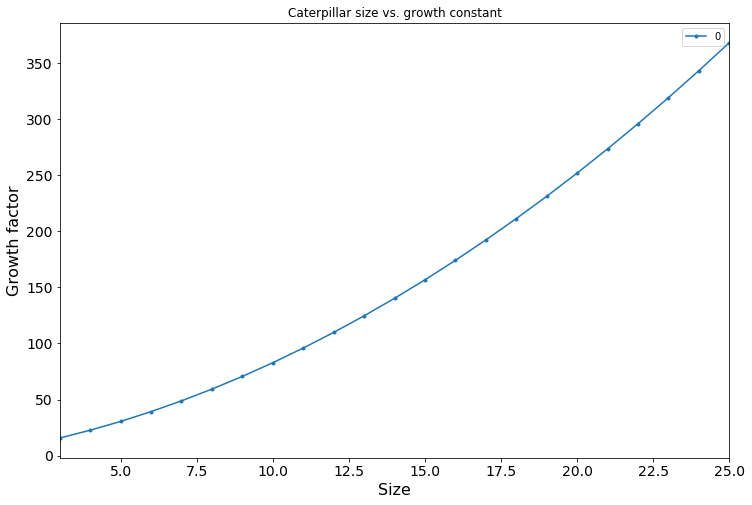

In [14]:
plt.figure()
ax_asympt3 = pd.DataFrame(RESULTS_ASYMPTOTICS_U_DL[0]).plot(kind='line', style='.-', figsize=(12,8), title='Caterpillar size vs. growth constant', fontsize=14)
ax_asympt3.set_xlabel('Size', fontsize=16)
ax_asympt3.set_ylabel('Growth factor', fontsize=16)
plt.savefig('Caterpillar_size_vs_exp_growth_U_DL.png')
plt.show()

In [15]:
def check_max_constant(df):
    df_max = df.idxmax(axis=1)
    for k in K_LIST:
        if df_max[k] == 0:
            print('k = '+str(k)+': the species tree with the maximum constant is the caterpillar')
check_max_constant(RESULTS_ASYMPTOTICS_U_DL)

k = 3: the species tree with the maximum constant is the caterpillar
k = 4: the species tree with the maximum constant is the caterpillar
k = 5: the species tree with the maximum constant is the caterpillar
k = 6: the species tree with the maximum constant is the caterpillar
k = 7: the species tree with the maximum constant is the caterpillar
k = 8: the species tree with the maximum constant is the caterpillar
k = 9: the species tree with the maximum constant is the caterpillar
k = 10: the species tree with the maximum constant is the caterpillar
k = 11: the species tree with the maximum constant is the caterpillar
k = 12: the species tree with the maximum constant is the caterpillar
k = 13: the species tree with the maximum constant is the caterpillar
k = 14: the species tree with the maximum constant is the caterpillar
k = 15: the species tree with the maximum constant is the caterpillar
k = 16: the species tree with the maximum constant is the caterpillar
k = 17: the species tree wi

So for the constants $\gamma_S$, the maximum is always attained with the caterpillar.

## Estimating the growth factor in an arbitrary model
We estimate the growth factor from the counting sequence using the formula
$$\alpha_S \simeq e^{\left(\frac{\ln\left(n^{3/2}h_S(n)\right)}{n}\right)}.$$

We could also look at estimating it by dividing the last two terms:
$$\alpha_S \simeq \frac{h_S(n)}{h_S(n-1)}.$$

In [16]:
def estimate_growth_constant_1(m,k,n):
    RESULTS_COUNTING_m_k_n = [ ]
    RESULTS_COUNTING_m_k_n_aux = RESULTS_COUNTING.loc[(m,k,n)]
    for i in RESULTS_COUNTING_m_k_n_aux.keys():
        RESULTS_COUNTING_m_k_n += RESULTS_COUNTING_m_k_n_aux[i]
    RESULTS_COUNTING_m_k_n_EXP_GROWTH = []
    for c in RESULTS_COUNTING_m_k_n:
        RESULTS_COUNTING_m_k_n_EXP_GROWTH.append(math.exp(math.log(n*math.sqrt(n)*c)/n))
    return(RESULTS_COUNTING_m_k_n_EXP_GROWTH)

RESULTS_ASYMPTOTICS_U_DLa_1 = pd.DataFrame({k: estimate_growth_constant_1(('U','DL'),k,50) for k in K_LIST})
RESULTS_ASYMPTOTICS_R_DL_1  = pd.DataFrame({k: estimate_growth_constant_1(('R','DL'),k,50) for k in K_LIST})
RESULTS_ASYMPTOTICS_U_DLT_1 = pd.DataFrame({k: estimate_growth_constant_1(('U','DLT'),k,50) for k in K_LIST})
RESULTS_ASYMPTOTICS_R_DLT_1 = pd.DataFrame({k: estimate_growth_constant_1(('R','DLT'),k,50) for k in K_LIST})

In [26]:
# Computing the ratio between the estimated and the exact growth constants
RATIO_RESULTS_ASYMPTOTICS_U_DL_1 = RESULTS_ASYMPTOTICS_U_DL.transpose() / RESULTS_ASYMPTOTICS_U_DLa_1 

<Figure size 432x288 with 0 Axes>

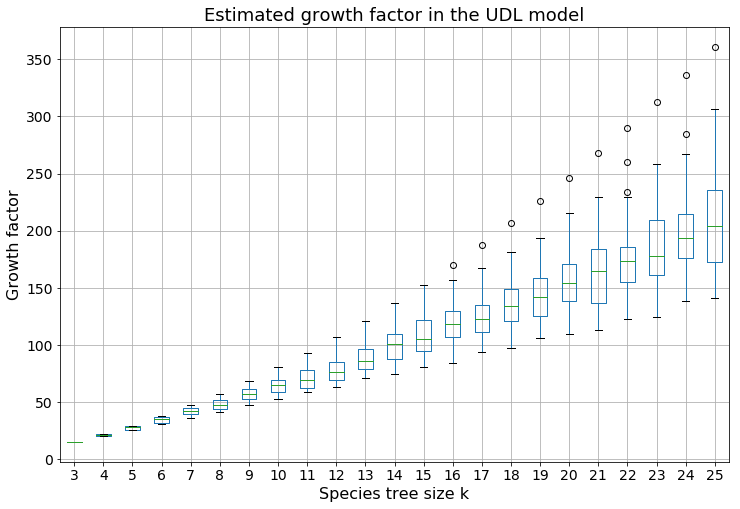

<Figure size 432x288 with 0 Axes>

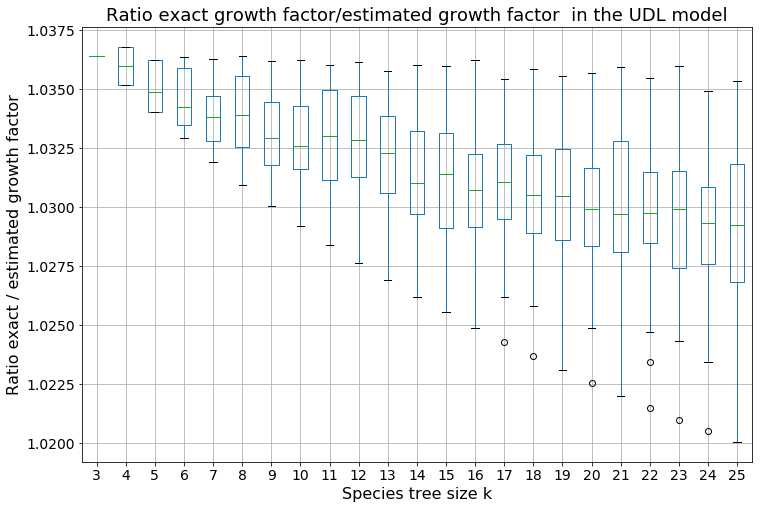

<Figure size 432x288 with 0 Axes>

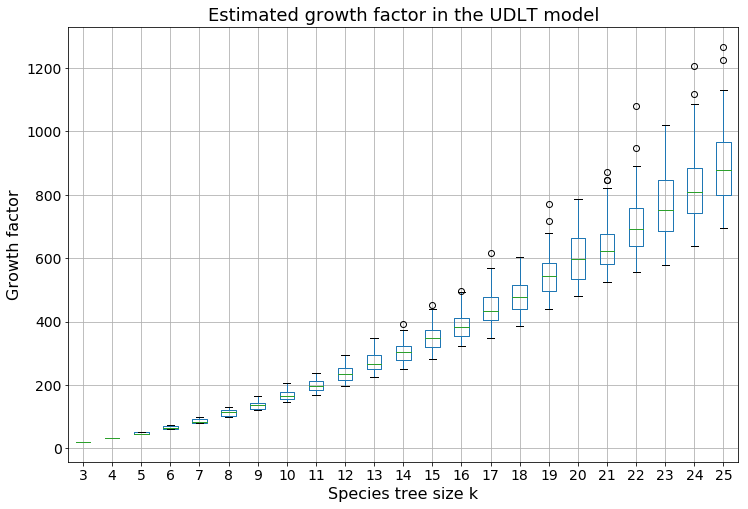

<Figure size 432x288 with 0 Axes>

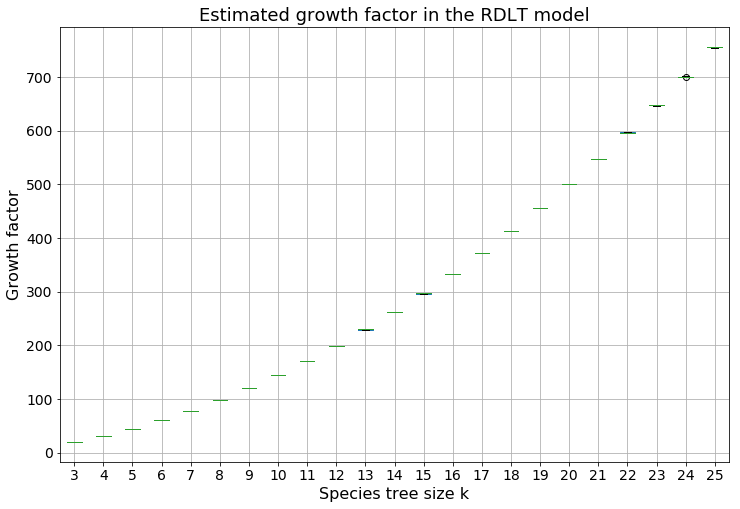

In [28]:
plt.figure()
ax_asympt4a = RESULTS_ASYMPTOTICS_U_DLa_1.plot(kind='box', grid=True, return_type='axes', figsize=(12,8), title='Estimated growth factor in the UDL model', fontsize=14)
ax_asympt4a.title.set_size(18)
ax_asympt4a.set_ylabel('Growth factor', fontsize=16)
ax_asympt4a.set_xlabel('Species tree size k', fontsize=16)
plt.savefig('paper/estimated_growth_factor_U_DL.png')
plt.show()

plt.figure()
ax_asympt4aa = RATIO_RESULTS_ASYMPTOTICS_U_DL_1.plot(kind='box', grid=True, return_type='axes', figsize=(12,8), title='Ratio exact growth factor/estimated growth factor  in the UDL model', fontsize=14)
ax_asympt4aa.title.set_size(18)
ax_asympt4aa.set_ylabel('Ratio exact / estimated growth factor', fontsize=16)
ax_asympt4aa.set_xlabel('Species tree size k', fontsize=16)
plt.savefig('paper/ratio_exact_estimated_growth_factor_U_DL.png')
plt.show()

plt.figure()
ax_asympt4b = RESULTS_ASYMPTOTICS_U_DLT_1.plot(kind='box', grid=True, return_type='axes', figsize=(12,8), title='Estimated growth factor in the UDLT model', fontsize=14)
ax_asympt4b.title.set_size(18)
ax_asympt4b.set_ylabel('Growth factor', fontsize=16)
ax_asympt4b.set_xlabel('Species tree size k', fontsize=16)
plt.savefig('paper/estimated_growth_factor_U_DLT.png')
plt.show()

plt.figure()
ax_asympt4c = RESULTS_ASYMPTOTICS_R_DLT_1.plot(kind='box', grid=True, return_type='axes', figsize=(12,8), title='Estimated growth factor in the RDLT model', fontsize=14)
ax_asympt4c.title.set_size(18)
ax_asympt4c.set_ylabel('Growth factor', fontsize=16)
ax_asympt4c.set_xlabel('Species tree size k', fontsize=16)
plt.savefig('paper/estimated_growth_factor_R_DLT.png')
plt.show()

We can make a few observations. 

The first one is the very large increase of the estimated growth constant in the U-DLT model compared to the U-DL mode.

The second one is that, when comparing the U-DL and R-DL models, the impact of the ranking is that it reduce the spread of the estimate growth constants.

Last, and extremely striking, in the R-DLT model, the growth constant seems to almost not vary. It looks like tin this model, the species tree topology does not matter at all.

## Ratio DLT-histories / DL-histories

Last, we compute the ratio between the number of DLT-histories and the number of DL-histories in the ranked and unranked models.

In [16]:
RESULTS_aux = {k:{n:{t:0 for t in S_TREES_INDEX} for n in N_LIST_REDUCED} for k in K_LIST_REDUCED}
for k in K_LIST_REDUCED:
    for n in N_LIST_REDUCED:
        for t in S_TREES_INDEX:
            dlth = RESULTS_COUNTING.at[(('U','DLT'),k,n),t][0]
            dlh  = RESULTS_COUNTING.at[(('U','DL'),k,n),t][0]
            RESULTS_aux[k][n][t] = dlth/dlh
RATIOS_U_DLT_DL = pd.DataFrame.from_dict({(k,n): RESULTS_aux[k][n]
                                        for k in RESULTS_aux.keys() 
                                        for n in RESULTS_aux[k].keys()},
                                        orient='index')

RESULTS_aux = {k:{n:{(t,r): 0 for r in R_LIST for t in S_TREES_INDEX} for n in N_LIST_REDUCED} for k in K_LIST_REDUCED}
for k in K_LIST_REDUCED:
    for n in N_LIST_REDUCED:
        for t in S_TREES_INDEX:
            for r in R_LIST:
                dlth = RESULTS_COUNTING.at[(('R','DLT'),k,n),t][r-1]
                dlh  = RESULTS_COUNTING.at[(('R','DL'),k,n),t][r-1]
                RESULTS_aux[k][n][(t,r)] = dlth/dlh
RATIOS_R_DLT_DL = pd.DataFrame.from_dict({(k,n): RESULTS_aux[k][n]
                                        for k in RESULTS_aux.keys() 
                                        for n in RESULTS_aux[k].keys()},
                                        orient='index')

<Figure size 432x288 with 0 Axes>

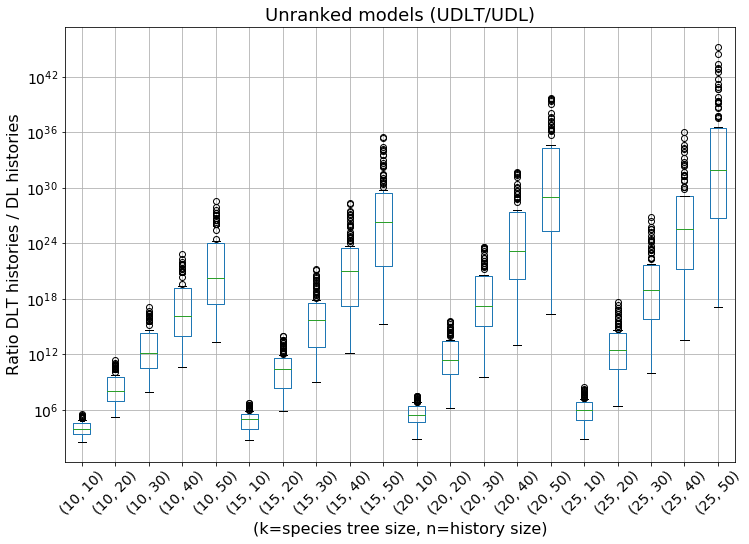

<Figure size 432x288 with 0 Axes>

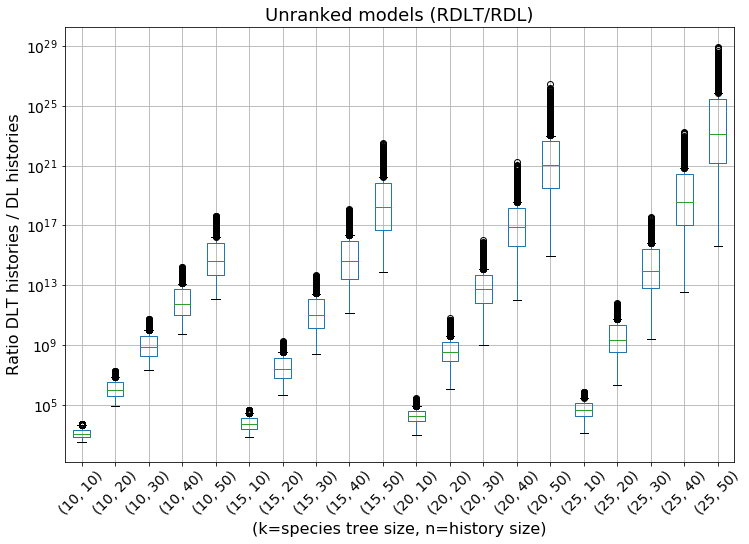

In [17]:
plt.figure()
ax_ratio1a = RATIOS_U_DLT_DL.transpose().plot(kind='box', grid=True, figsize=(12,8), return_type='axes', title='Unranked models (UDLT/UDL)', fontsize=14)
ax_ratio1a.title.set_size(18)
ax_ratio1a.set_yscale('log')
ax_ratio1a.set_ylabel('Ratio DLT histories / DL histories', fontsize=16)
plt.xticks(rotation=45)
ax_ratio1a.set_xlabel('(k=species tree size, n=history size)', fontsize=16)
plt.savefig('paper/ratio_UDLT_UDL_per_tree.png')
plt.show()

plt.figure()
ax_ratio1b = RATIOS_R_DLT_DL.transpose().plot(kind='box', grid=True, figsize=(12,8), return_type='axes', title='Unranked models (RDLT/RDL)', fontsize=14)
ax_ratio1b.title.set_size(18)
ax_ratio1b.set_yscale('log')
ax_ratio1b.set_ylabel('Ratio DLT histories / DL histories', fontsize=16)
plt.xticks(rotation=45)
ax_ratio1b.set_xlabel('(k=species tree size, n=history size)', fontsize=16)
plt.savefig('paper/ratio_RDLT_RDL_per_tree.png')
plt.show()

We can observe again the impact of adding transfers in a model, that results in a large increase of the number of histories.

## Score distribution from sampling

For each of the htree models UDL, UDLT, RDLT, we considered $(k,n)=(8,10),(8,15),(16,20),(16,30)$ and for each parameter setting we generated 5 random species trees (plus ranking in the RDLT model) and $10,000$ random histories. We show the distribution of the number of duplications, losses, HGTs and score (defined as the sum of the three kinds of events).

In [18]:
def read_scores(k,n,m,s):
    RESULTS_SCORES_aux  = {}
    with gzip.open(PREFIX_SCORES+str(k)+'_'+str(n)+'_'+m+'.gz', 'r') as f:
        reader = csv.reader(io.TextIOWrapper(f, newline=""),delimiter='\t')        
        for row in reader:
            if row[0][0] == '#': #Species tree
                treeIndex = int(row[0].replace('# S_',''))
                RESULTS_SCORES_aux[treeIndex]  = {'D':[], 'L':[], 'T':[], 'A':[]}
                sampleIndex = 0
            else:
                row1 = row[0].rstrip().split(' ')
                D = int(row1[k].split(':')[1])
                L = int(row1[k+1].split(':')[1])
                T = int(row1[k+2].split(':')[1])
                RESULTS_SCORES_aux[treeIndex]['D'].append(D)
                RESULTS_SCORES_aux[treeIndex]['L'].append(L)
                RESULTS_SCORES_aux[treeIndex]['T'].append(T)
                RESULTS_SCORES_aux[treeIndex]['A'].append(D+L+T)
                sampleIndex += 1
                
    RESULTS_SCORES = pd.DataFrame.from_dict({(t): RESULTS_SCORES_aux[t]
                                            for t in RESULTS_SCORES_aux.keys()},
                                            orient='index')
    return(RESULTS_SCORES)

In [19]:
SCORES_16_30_UDL  = read_scores(16,30,'U_DL',10000)
SCORES_16_30_UDLT = read_scores(16,30,'U_DLT',10000)
SCORES_16_30_RDLT = read_scores(16,30,'R_DLT',10000)

<Figure size 432x288 with 0 Axes>

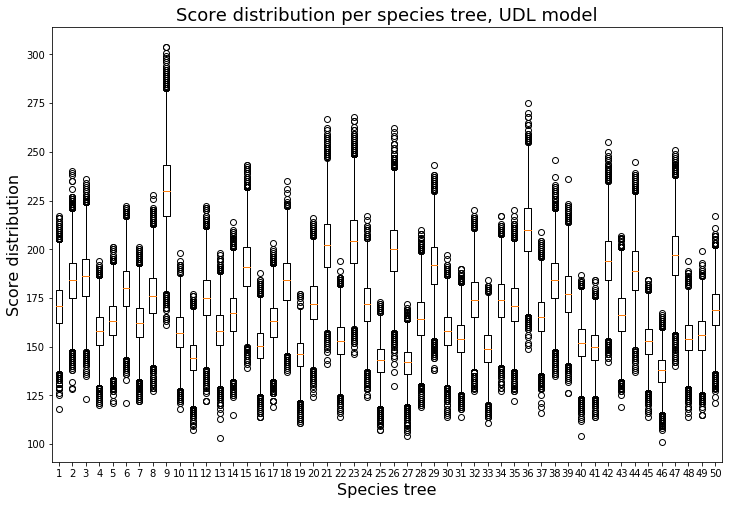

<Figure size 432x288 with 0 Axes>

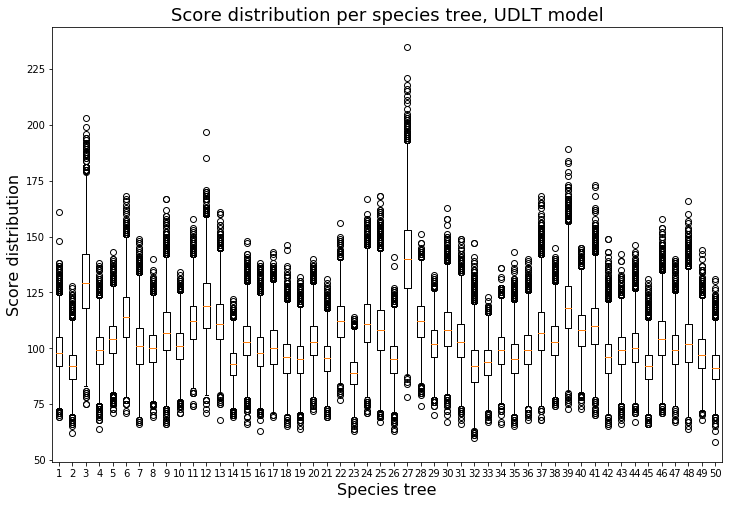

<Figure size 432x288 with 0 Axes>

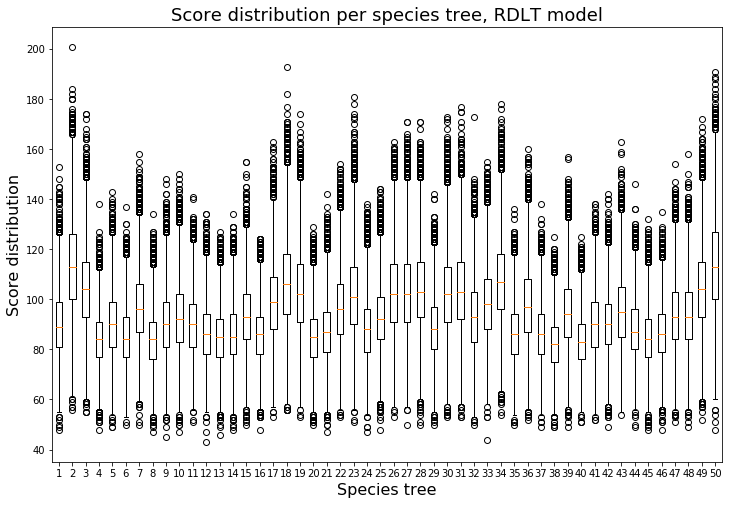

In [20]:
# Score distribution UDL, UDLT, RDLT

plt.figure()
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)    
plt.title('Score distribution per species tree, UDL model', fontsize=14)
_ = plt.boxplot(np.array(SCORES_16_30_UDL['A']))
ax.title.set_size(18)
ax.set_xlabel('Species tree', fontsize=16)
ax.set_ylabel('Score distribution', fontsize=16)
plt.savefig('paper/scores_16_30_UDL.png')
plt.show()

plt.figure()
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)    
plt.title('Score distribution per species tree, UDLT model', fontsize=14)
_ = plt.boxplot(np.array(SCORES_16_30_UDLT['A']))
ax.title.set_size(18)
ax.set_xlabel('Species tree', fontsize=16)
ax.set_ylabel('Score distribution', fontsize=16)
plt.savefig('paper/scores_16_30_UDLT.png')
plt.show()

plt.figure()
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)    
plt.title('Score distribution per species tree, RDLT model', fontsize=14)
_ = plt.boxplot(np.array(SCORES_16_30_RDLT['A']))
ax.title.set_size(18)
ax.set_xlabel('Species tree', fontsize=16)
ax.set_ylabel('Score distribution', fontsize=16)
plt.savefig('paper/scores_16_30_RDLT.png')
plt.show()

<Figure size 432x288 with 0 Axes>

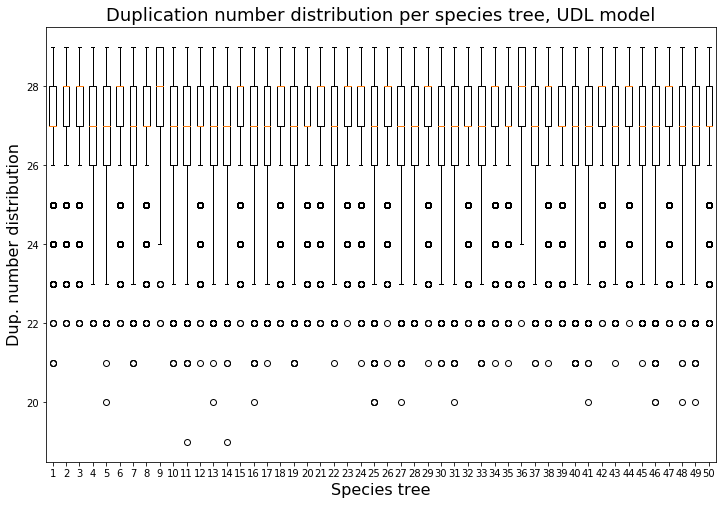

<Figure size 432x288 with 0 Axes>

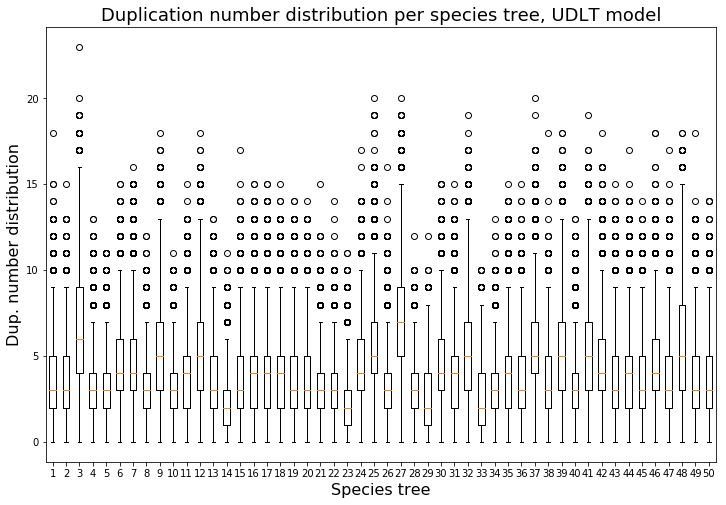

<Figure size 432x288 with 0 Axes>

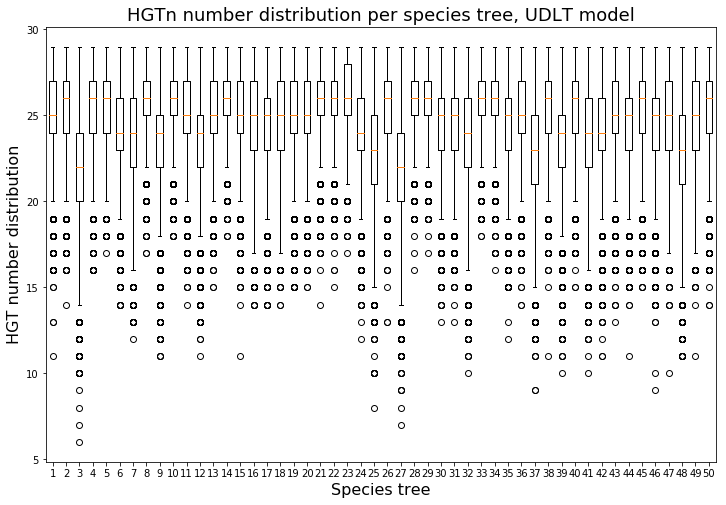

<Figure size 432x288 with 0 Axes>

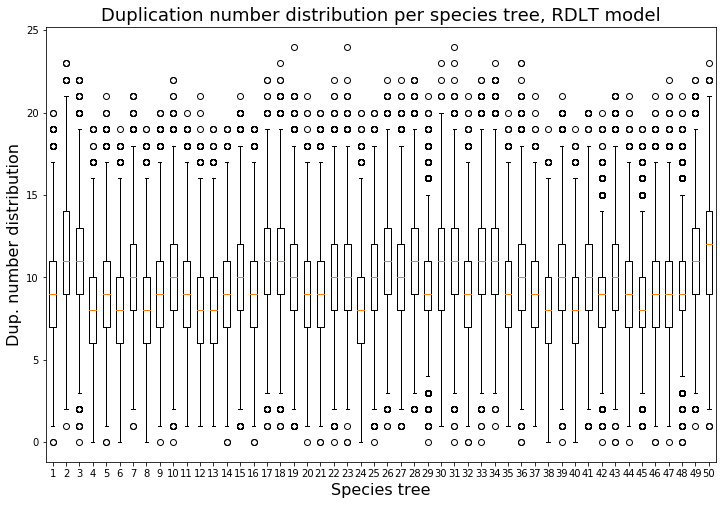

<Figure size 432x288 with 0 Axes>

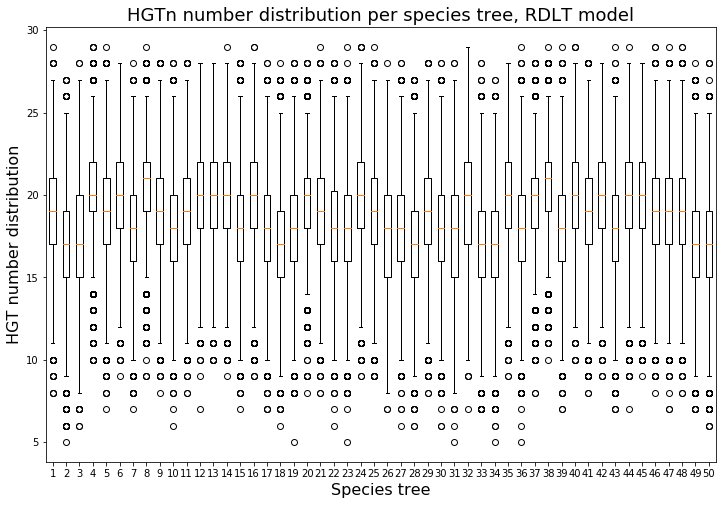

In [21]:
# Duplications/HGTs distribution UDL, UDLT, RDLT

plt.figure()
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)    
plt.title('Duplication number distribution per species tree, UDL model', fontsize=14)
_ = plt.boxplot(np.array(SCORES_16_30_UDL['D']))
ax.title.set_size(18)
ax.set_xlabel('Species tree', fontsize=16)
ax.set_ylabel('Dup. number distribution', fontsize=16)
plt.savefig('paper/duplications_16_30_UDL.png')
plt.show()

plt.figure()
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)    
plt.title('Duplication number distribution per species tree, UDLT model', fontsize=14)
_ = plt.boxplot(np.array(SCORES_16_30_UDLT['D']))
ax.title.set_size(18)
ax.set_xlabel('Species tree', fontsize=16)
ax.set_ylabel('Dup. number distribution', fontsize=16)
plt.savefig('paper/duplications_16_30_UDLT.png')
plt.show()

plt.figure()
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)    
plt.title('HGTn number distribution per species tree, UDLT model', fontsize=14)
_ = plt.boxplot(np.array(SCORES_16_30_UDLT['T']))
ax.title.set_size(18)
ax.set_xlabel('Species tree', fontsize=16)
ax.set_ylabel('HGT number distribution', fontsize=16)
plt.savefig('paper/HGT_16_30_UDLT.png')
plt.show()

plt.figure()
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)    
plt.title('Duplication number distribution per species tree, RDLT model', fontsize=14)
_ = plt.boxplot(np.array(SCORES_16_30_RDLT['D']))
ax.title.set_size(18)
ax.set_xlabel('Species tree', fontsize=16)
ax.set_ylabel('Dup. number distribution', fontsize=16)
plt.savefig('paper/duplications_16_30_RDLT.png')
plt.show()

plt.figure()
fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(111)    
plt.title('HGTn number distribution per species tree, RDLT model', fontsize=14)
_ = plt.boxplot(np.array(SCORES_16_30_RDLT['T']))
ax.title.set_size(18)
ax.set_xlabel('Species tree', fontsize=16)
ax.set_ylabel('HGT number distribution', fontsize=16)
plt.savefig('paper/HGT_16_30_RDLT.png')
plt.show()